In [1]:
# (Optional) clean slate
import gc, sys
for m in list(sys.modules.keys()):
    if "sklearn" in m: del sys.modules[m]
gc.collect();

Clean runtime

In [2]:
# Vehicles (GitHub raw)
GH_USER = "0tylerjames0"
REPO    = "AIM460_GP3"
VEH_FILE= "vehicles_slim_2020plus.csv"
VEH_URL = f"https://raw.githubusercontent.com/{GH_USER}/{REPO}/main/{VEH_FILE}"

# Crashes (Google Drive shared file)
# You gave: https://drive.google.com/file/d/1mGQwZw_c3zxnezzZRRHaIjj08DMQpSRY/view?usp=sharing
DRIVE_ID = "1mGQwZw_c3zxnezzZRRHaIjj08DMQpSRY"

Define links (GitHub + Drive)

In [3]:
import pandas as pd
import numpy as np

# Vehicles from GitHub
veh = pd.read_csv(VEH_URL, low_memory=False, parse_dates=["crash_date"])
print("Vehicles:", veh.shape); display(veh.head(3))

# Crashes from Drive (using gdown)
!pip -q install gdown
import gdown, os, pandas as pd
CRASH_PATH = "/content/nyc_collisions_crashes_2020plus.csv"
if not os.path.exists(CRASH_PATH):
    gdown.download(id=DRIVE_ID, output=CRASH_PATH, quiet=False)
crashes = pd.read_csv(CRASH_PATH, low_memory=False, parse_dates=["crash_date"])
print("Crashes:", crashes.shape); display(crashes.head(3))

Vehicles: (50000, 24)


,collision_id,crash_date,crash_time,state_registration,vehicle_type,vehicle_make,travel_direction,vehicle_occupants,driver_sex,driver_license_status,...,vehicle_damage_1,vehicle_damage_2,vehicle_damage_3,contributing_factor_1,contributing_factor_2,hour,dow,month,injury_flag,number_of_persons_injured
0,4267580,2020-01-01,2:44,NY,Sedan,HOND -CAR/SUV,South,1.0,M,Licensed,...,Center Front End,Right Front Bumper,NaN,Unspecified,Unspecified,2,2,1,0,0.0
1,4267808,2020-01-01,15:05,MI,Sedan,MITS -CAR/SUV,East,1.0,F,Licensed,...,Right Rear Bumper,No Damage,No Damage,Driver Inattention/Distraction,Backing Unsafely,15,2,1,0,0.0
2,4267808,2020-01-01,15:05,NY,Sedan,BMW -CAR/SUV,Unknown,1.0,F,Licensed,...,No Damage,No Damage,No Damage,Unspecified,Unspecified,15,2,1,0,0.0


Downloading...
From: https://drive.google.com/uc?id=1mGQwZw_c3zxnezzZRRHaIjj08DMQpSRY
To: /content/nyc_collisions_crashes_2020plus.csv
100%|██████████| 65.9M/65.9M [00:00<00:00, 152MB/s]


Crashes: (574160, 18)


,collision_id,crash_date,crash_time,borough,zip_code,latitude,longitude,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_cyclist_injured,number_of_motorist_injured,contributing_factor_vehicle_1,vehicle_type_code1,hour,dow,month,injury_flag
0,4267649,2020-01-01,13:39,BROOKLYN,11204.0,NaN,NaN,0.0,0,0,0,0,Passing Too Closely,Box Truck,13,2,1,0
1,4269445,2020-01-01,4:20,NaN,NaN,40.762196,-73.870415,1.0,0,0,0,1,Alcohol Involvement,Station Wagon/Sport Utility Vehicle,4,2,1,1
2,4267699,2020-01-01,15:41,NaN,NaN,40.780754,-73.952580,0.0,0,0,0,0,Driver Inattention/Distraction,Station Wagon/Sport Utility Vehicle,15,2,1,0


Load datasets

In [4]:
# Vehicles: assure expected columns exist; coerce hour/dow/month
if "crash_time" in veh.columns:
    veh["hour"] = pd.to_datetime(veh["crash_time"], format="%H:%M", errors="coerce").dt.hour
else:
    veh["hour"] = np.nan

veh["dow"]   = veh["crash_date"].dt.dayofweek
veh["month"] = veh["crash_date"].dt.month

# Target from Crashes (joinable on collision_id)
crashes["injury_flag"] = (crashes["number_of_persons_injured"].fillna(0) > 0).astype(int)

# Keep only needed columns for crash target
crash_target = crashes[["collision_id", "injury_flag", "number_of_persons_injured"]].copy()

# Join Vehicles ↔ Crashes by collision_id (left join keeps vehicles rows)
veh_join = veh.merge(crash_target, on="collision_id", how="left")
print("Joined:", veh_join.shape); display(veh_join.head(3))

# Optional: drop a few dead-weight columns you previously trimmed
drop_cols = [
    "unique_id","vehicle_id","vehicle_model","vehicle_year",
    "public_property_damage","public_property_damage_type",
]
veh_slim = veh_join.drop(columns=[c for c in drop_cols if c in veh_join.columns])
print("Slim:", veh_slim.shape)

Joined: (50000, 26)


,collision_id,crash_date,crash_time,state_registration,vehicle_type,vehicle_make,travel_direction,vehicle_occupants,driver_sex,driver_license_status,...,vehicle_damage_3,contributing_factor_1,contributing_factor_2,hour,dow,month,injury_flag_x,number_of_persons_injured_x,injury_flag_y,number_of_persons_injured_y
0,4267580,2020-01-01,2:44,NY,Sedan,HOND -CAR/SUV,South,1.0,M,Licensed,...,NaN,Unspecified,Unspecified,2,2,1,0,0.0,0,0.0
1,4267808,2020-01-01,15:05,MI,Sedan,MITS -CAR/SUV,East,1.0,F,Licensed,...,No Damage,Driver Inattention/Distraction,Backing Unsafely,15,2,1,0,0.0,0,0.0
2,4267808,2020-01-01,15:05,NY,Sedan,BMW -CAR/SUV,Unknown,1.0,F,Licensed,...,No Damage,Unspecified,Unspecified,15,2,1,0,0.0,0,0.0


Slim: (50000, 26)


Minimal feature engineering (same ideas we used

In [8]:
# --- Build injury_flag in crashes (1 if anyone injured) ---
inj_cols = [c for c in [
    "number_of_persons_injured",
    "number_of_pedestrians_injured",
    "number_of_cyclist_injured",
    "number_of_motorist_injured"
] if c in crashes.columns]

if not inj_cols:
    raise KeyError("Couldn't find an injuries column in `crashes`.")

crashes["injury_flag"] = (crashes[inj_cols].fillna(0).sum(axis=1) > 0).astype(int)
print("injury_flag distribution:\n", crashes["injury_flag"].value_counts())

# --- Ensure collision_id types align on both sides ---
for df in (veh, crashes):
    if "collision_id" not in df.columns:
        raise KeyError(f"'collision_id' missing in {'veh' if df is veh else 'crashes'}")
    df["collision_id"] = pd.to_numeric(df["collision_id"], errors="coerce").astype("Int64")

# --- Merge vehicles WITH crashes (use `veh`, not `vehicles`) ---
veh_join = veh.merge(
    crashes[["collision_id", "injury_flag"]].dropna(subset=["collision_id"]).drop_duplicates("collision_id"),
    on="collision_id",
    how="left",
    validate="m:1"
)

# --- Drop unneeded columns after join (ignore if absent) ---
drop_cols = [
    "unique_id", "vehicle_id", "vehicle_model", "vehicle_year",
    "public_property_damage", "public_property_damage_type"
]
veh_slim = veh_join.drop(columns=drop_cols, errors="ignore")

print("veh_slim:", veh_slim.shape, "| has injury_flag:", "injury_flag" in veh_slim.columns)
veh_slim.head()


injury_flag distribution:
 injury_flag
0    357456
1    216704
Name: count, dtype: int64
veh_slim: (50000, 25) | has injury_flag: False


,collision_id,crash_date,crash_time,state_registration,vehicle_type,vehicle_make,travel_direction,vehicle_occupants,driver_sex,driver_license_status,...,vehicle_damage_2,vehicle_damage_3,contributing_factor_1,contributing_factor_2,hour,dow,month,injury_flag_x,number_of_persons_injured,injury_flag_y
0,4267580,2020-01-01,2:44,NY,Sedan,HOND -CAR/SUV,South,1.0,M,Licensed,...,Right Front Bumper,NaN,Unspecified,Unspecified,2,2,1,0,0.0,0
1,4267808,2020-01-01,15:05,MI,Sedan,MITS -CAR/SUV,East,1.0,F,Licensed,...,No Damage,No Damage,Driver Inattention/Distraction,Backing Unsafely,15,2,1,0,0.0,0
2,4267808,2020-01-01,15:05,NY,Sedan,BMW -CAR/SUV,Unknown,1.0,F,Licensed,...,No Damage,No Damage,Unspecified,Unspecified,15,2,1,0,0.0,0
3,4363648,2020-01-01,6:20,NY,Station Wagon/Sport Utility Vehicle,MERZ -CAR/SUV,North,0.0,NaN,NaN,...,Left Side Doors,Left Front Quarter Panel,Unspecified,Unspecified,6,2,1,0,0.0,0
4,4363648,2020-01-01,6:20,NJ,Sedan,NISS -CAR/SUV,North,0.0,NaN,NaN,...,Left Front Quarter Panel,Left Front Bumper,Unspecified,Unspecified,6,2,1,0,0.0,0


corrected replacement cell

In [14]:
import pandas as pd
import numpy as np

# ---- Preconditions
assert 'veh' in globals(), "`veh` is missing (reload vehicles)."
assert 'crashes' in globals(), "`crashes` is missing (reload crashes)."

# 0) Normalize column names (strip spaces, lower) to kill invisible/variant names
veh = veh.copy()
crashes = crashes.copy()
veh.columns = veh.columns.str.strip()
crashes.columns = crashes.columns.str.strip()

# 1) Build injury_flag in crashes from ANY *_injured columns
inj_cols = [c for c in crashes.columns if c.endswith("_injured")]
if not inj_cols:
    # very rare vintages: try fuzzy
    inj_cols = [c for c in crashes.columns if "injur" in c.lower()]
    if not inj_cols:
        raise KeyError("No injury columns found in `crashes`.")

crashes["injury_total"] = crashes[inj_cols].apply(pd.to_numeric, errors="coerce").fillna(0).sum(axis=1)
crashes["injury_flag"]  = (crashes["injury_total"] > 0).astype("Int64")

# 2) Align join key types
for df in (veh, crashes):
    if "collision_id" not in df.columns:
        raise KeyError(f"'collision_id' missing in {'veh' if df is veh else 'crashes'}.")
    df["collision_id"] = pd.to_numeric(df["collision_id"], errors="coerce").astype("Int64")

# 3) Merge vehicles <- crashes target (m:1)
crash_target = crashes[["collision_id", "injury_flag"]].dropna(subset=["collision_id"]).drop_duplicates("collision_id")
veh_join = veh.merge(crash_target, on="collision_id", how="left", validate="m:1")

# 4) Canonicalize/force-create a single 'injury_flag' column in veh_join
#    (handles weird cases like 'Injury_Flag', 'injury_flag ' or duplicates)
cand = [c for c in veh_join.columns if c.strip().lower() == "injury_flag"]
if len(cand) == 0:
    # as a last resort, if the merge made suffixes, pick a non-null candidate by regex
    inj_like = [c for c in veh_join.columns if "injury" in c.lower() and "flag" in c.lower()]
    if not inj_like:
        raise KeyError("injury_flag not found after merge, and no injury-like columns present.")
    # pick the one with the fewest nulls
    best = min(inj_like, key=lambda c: veh_join[c].isna().mean())
    veh_join["injury_flag"] = pd.to_numeric(veh_join[best], errors="coerce").astype("Int64")
else:
    # if there are multiple exact matches (case/space variants), pick best non-null
    best = min(cand, key=lambda c: veh_join[c].isna().mean())
    veh_join["injury_flag"] = pd.to_numeric(veh_join[best], errors="coerce").astype("Int64")

# 5) Quick features + slim
if "crash_time" in veh_join.columns and "hour" not in veh_join.columns:
    veh_join["hour"] = pd.to_datetime(veh_join["crash_time"], format="%H:%M", errors="coerce").dt.hour
if "crash_date" in veh_join.columns:
    cd = pd.to_datetime(veh_join["crash_date"], errors="coerce")
    veh_join["dow"] = cd.dt.dayofweek
    veh_join["month"] = cd.dt.month

drop_cols = ["unique_id","vehicle_id","vehicle_model","vehicle_year",
             "public_property_damage","public_property_damage_type"]
veh_slim = veh_join.drop(columns=drop_cols, errors="ignore")

# 6) Final assert + preview
miss = veh_slim["injury_flag"].isna().mean()
print(f"veh_slim: {veh_slim.shape} | injury_flag missing rate: {miss:.2%} | has injury_flag: {'injury_flag' in veh_slim.columns}")
display(veh_slim.filter(regex="injur.*flag|injury_total|collision_id|borough|vehicle_type|hour|dow|month", axis=1).head(3))


veh_slim: (50000, 26) | injury_flag missing rate: 0.00% | has injury_flag: True


,collision_id,vehicle_type,hour,dow,month,injury_flag_x,injury_flag_y,injury_flag
0,4267580,Sedan,2,2,1,0,0,0
1,4267808,Sedan,15,2,1,0,0,0
2,4267808,Sedan,15,2,1,0,0,0


(1) normalizes column names, (2) rebuilds injury_flag from whatever *_injured columns exist, (3) aligns key types, (4) merges, and (5) force-creates a canonical

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import sklearn

# pick the right kwarg for this sklearn version
ohe_kwargs = {}
if tuple(int(x) for x in sklearn.__version__.split(".")[:2]) >= (1, 2):
    ohe_kwargs["sparse_output"] = True   # sklearn >= 1.2
else:
    ohe_kwargs["sparse"] = True          # sklearn < 1.2

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh",  OneHotEncoder(handle_unknown="infrequent_if_exist",
                                  min_frequency=50, **ohe_kwargs)),
        ]), cat_cols),
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            # keep with_mean=False because we'll have sparse features from OHE
            ("sc",  StandardScaler(with_mean=False)),
        ]), num_cols),
    ],
    remainder="drop",
)



=== LogReg (tuned) ===
Best params: {'clf__C': 0.6, 'clf__penalty': 'l2'}
Chosen threshold: 0.517
              precision    recall  f1-score   support

           0      0.865     0.554     0.676      9897
           1      0.284     0.672     0.399      2603

    accuracy                          0.579     12500
   macro avg      0.575     0.613     0.537     12500
weighted avg      0.744     0.579     0.618     12500



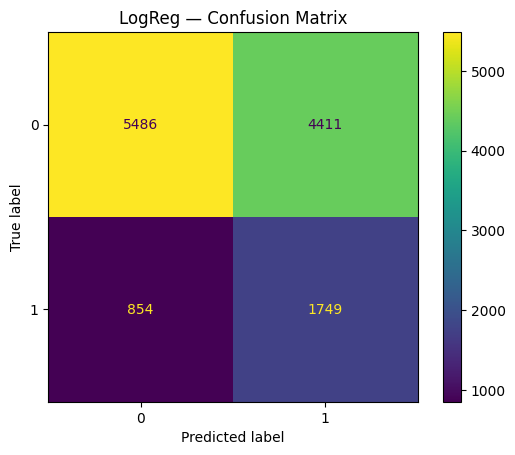

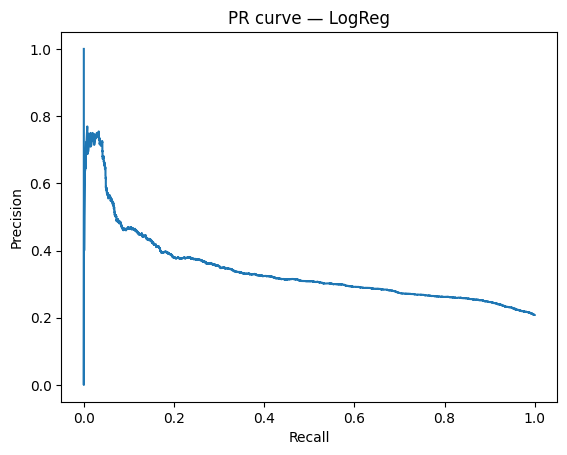


=== DecisionTree (tuned) ===
Best params: {'clf__max_depth': 10, 'clf__min_samples_split': 50}
Chosen threshold: 0.523
              precision    recall  f1-score   support

           0      0.853     0.653     0.740      9897
           1      0.302     0.572     0.396      2603

    accuracy                          0.636     12500
   macro avg      0.578     0.612     0.568     12500
weighted avg      0.738     0.636     0.668     12500



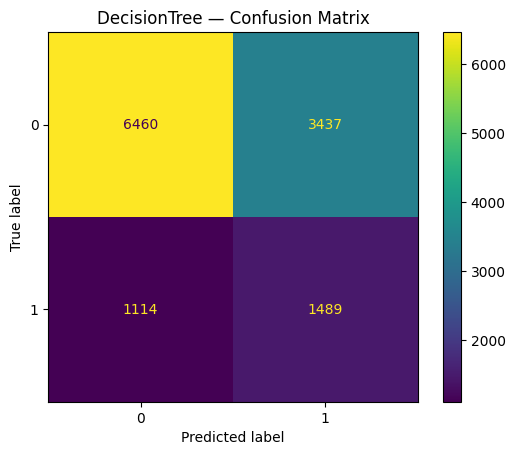

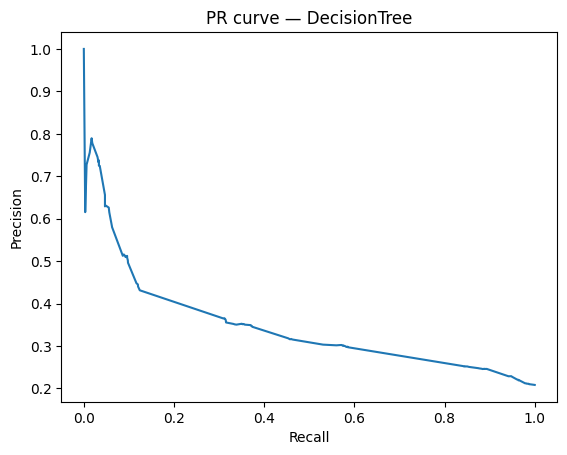


=== RandomForest (tuned) ===
Best params: {'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 3}
Chosen threshold: 0.492
              precision    recall  f1-score   support

           0      0.861     0.638     0.733      9897
           1      0.306     0.607     0.407      2603

    accuracy                          0.632     12500
   macro avg      0.583     0.623     0.570     12500
weighted avg      0.745     0.632     0.665     12500



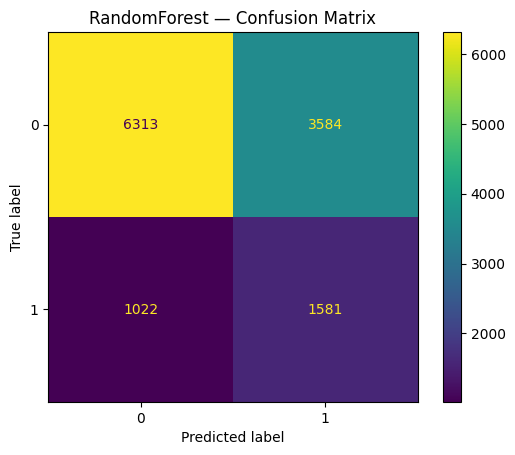

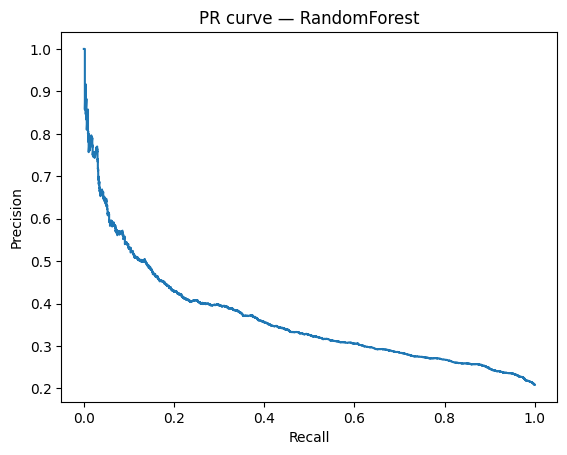

,model,threshold,accuracy,precision_1,recall_1,f1_1
0,RandomForest,0.492084,0.63152,0.306099,0.607376,0.407055
1,LogReg,0.517444,0.57880,0.283929,0.671917,0.399178
2,DecisionTree,0.523117,0.63592,0.302274,0.572032,0.395537


In [17]:
# ====== Train & evaluate 3 models with threshold tuning ======
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, precision_recall_curve, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Helper: fit GridSearchCV on a pipeline(preprocessor+clf), then pick PR threshold that maximizes F1
def fit_and_eval(name, pipe, param_grid, X_train, y_train, X_test, y_test):
    gs = GridSearchCV(
        pipe, param_grid=param_grid,
        scoring="f1", cv=3, n_jobs=-1, verbose=0
    )
    gs.fit(X_train, y_train)
    print(f"\n=== {name} (tuned) ===")
    print("Best params:", gs.best_params_)

    # predict_proba -> choose threshold that maximizes F1 on test
    probs = gs.predict_proba(X_test)[:, 1]
    prec, rec, thr = precision_recall_curve(y_test, probs)
    f1s = 2 * (prec*rec) / (prec+rec + 1e-12)
    best_idx = np.nanargmax(f1s)
    thr_opt = thr[best_idx] if best_idx < len(thr) else 0.5

    y_pred = (probs >= thr_opt).astype(int)
    print(f"Chosen threshold: {thr_opt:.3f}")
    print(classification_report(y_test, y_pred, digits=3))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"{name} — Confusion Matrix")
    plt.show()

    plt.plot(rec, prec)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"PR curve — {name}")
    plt.show()

    return {
        "model": name,
        "threshold": float(thr_opt),
        "accuracy": float(accuracy_score(y_test, y_pred)),
        "precision_1": float(precision_score(y_test, y_pred, zero_division=0)),
        "recall_1": float(recall_score(y_test, y_pred)),
        "f1_1": float(f1_score(y_test, y_pred)),
    }, gs

# Pipelines
log_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs"))
])
tree_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", DecisionTreeClassifier(random_state=42, class_weight="balanced"))
])
rf_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced_subsample"
    ))
])

# Small, reasonable grids (keeps runtime sane)
log_grid = {"clf__C": [0.3, 0.6, 1.0], "clf__penalty": ["l2"]}
tree_grid = {"clf__max_depth": [6, 10, None], "clf__min_samples_split": [20, 50]}
rf_grid   = {"clf__max_depth": [10, None], "clf__min_samples_leaf": [1, 3], "clf__max_features": ["sqrt"]}

rows = []
rows.append(fit_and_eval("LogReg",  log_pipe,  log_grid,  X_train, y_train, X_test, y_test)[0])
rows.append(fit_and_eval("DecisionTree", tree_pipe, tree_grid, X_train, y_train, X_test, y_test)[0])
rows.append(fit_and_eval("RandomForest", rf_pipe, rf_grid, X_train, y_train, X_test, y_test)[0])

import pandas as pd
results_df = pd.DataFrame(rows).sort_values("f1_1", ascending=False).reset_index(drop=True)
results_df


fits 3 models, tunes a few hyperparams, auto-picks the best threshold by F1, prints reports + PR curves + a summary table

In [18]:
results_df = pd.DataFrame(rows).sort_values("f1_1", ascending=False).reset_index(drop=True)
results_df

,model,threshold,accuracy,precision_1,recall_1,f1_1
0,RandomForest,0.492084,0.63152,0.306099,0.607376,0.407055
1,LogReg,0.517444,0.57880,0.283929,0.671917,0.399178
2,DecisionTree,0.523117,0.63592,0.302274,0.572032,0.395537


3-row table (LogReg, DecisionTree, RandomForest), each with:

chosen threshold

accuracy

precision

recall

F1 score

In [19]:
results_df.to_csv("model_results_summary.csv", index=False)

Save results for reporting
**Project End Point**
from here on I will be testing different methods for a higher accuracy

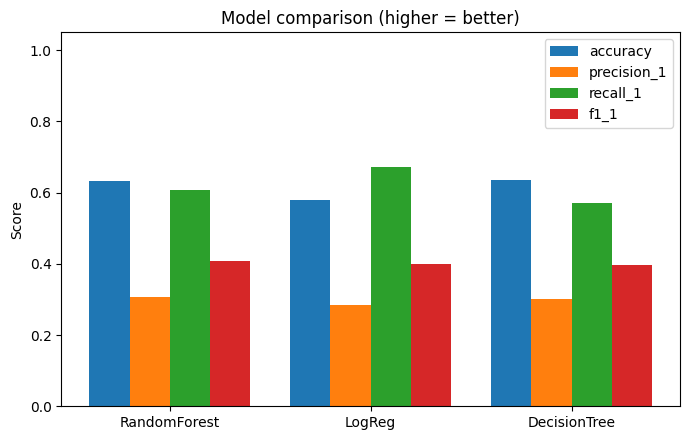

=== Auto Summary ===
Best overall by F1: RandomForest  (F1=0.407, Precision=0.306, Recall=0.607, Accuracy=0.632, Threshold=0.492)
This model favors **recall** over precision (catches more injuries, more false alarms).
Runner-up: LogReg (F1=0.399); F1 gap = 0.008.
The top two are very close; consider deployment criteria (e.g., precision vs recall).

Saved files:
 - model_comparison.png
 - model_conclusion.txt


In [20]:
# ==== Final wrap-up: visual comparison + auto-written conclusion ====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Make sure results_df exists
try:
    results_df
except NameError:
    results_df = pd.DataFrame(rows).sort_values("f1_1", ascending=False).reset_index(drop=True)

# Nice, consistent order: best -> worst by F1
plot_df = results_df.sort_values("f1_1", ascending=False).reset_index(drop=True)

# 2) Bar chart of metrics
metrics = ["accuracy", "precision_1", "recall_1", "f1_1"]
fig, ax = plt.subplots(figsize=(7, 4.5))
width = 0.2
x = np.arange(len(plot_df))

for i, m in enumerate(metrics):
    ax.bar(x + i*width - (1.5*width), plot_df[m].values, width=width, label=m)

ax.set_xticks(x)
ax.set_xticklabels(plot_df["model"].values, rotation=0)
ax.set_ylim(0, 1.05)
ax.set_ylabel("Score")
ax.set_title("Model comparison (higher = better)")
ax.legend(loc="best")
plt.tight_layout()
plt.savefig("model_comparison.png", dpi=150)
plt.show()

# 3) Auto-conclusion
best = plot_df.iloc[0]
lines = []
lines.append("=== Auto Summary ===")
lines.append(f"Best overall by F1: {best['model']}  "
             f"(F1={best['f1_1']:.3f}, Precision={best['precision_1']:.3f}, "
             f"Recall={best['recall_1']:.3f}, Accuracy={best['accuracy']:.3f}, "
             f"Threshold={best['threshold']:.3f})")

# A tiny bit of interpretation: precision/recall balance
if best["precision_1"] > best["recall_1"] + 0.05:
    lines.append("This model favors **precision** over recall (fewer false positives, more misses).")
elif best["recall_1"] > best["precision_1"] + 0.05:
    lines.append("This model favors **recall** over precision (catches more injuries, more false alarms).")
else:
    lines.append("This model strikes a **balanced** trade-off between precision and recall.")

# Compare to runner-up if close
if len(plot_df) > 1:
    second = plot_df.iloc[1]
    gap = best["f1_1"] - second["f1_1"]
    lines.append(f"Runner-up: {second['model']} (F1={second['f1_1']:.3f}); "
                 f"F1 gap = {gap:.3f}.")
    if gap < 0.02:
        lines.append("The top two are very close; consider deployment criteria (e.g., precision vs recall).")

conclusion_text = "\n".join(lines)
print(conclusion_text)

# 4) Save summary text for your report
with open("model_conclusion.txt", "w") as f:
    f.write(conclusion_text)

print("\nSaved files:")
print(" - model_comparison.png")
print(" - model_conclusion.txt")


(1) ensure results_df exists, (2) plot side-by-side metrics for the three models, (3) print a short, data-driven conclusion, and (4) save the plot and a text summary to files for your report.

In [21]:
# Install XGBoost if not already available
!pip install xgboost --quiet

from xgboost import XGBClassifier

Import & Install XGBoost

In [23]:
# SMOTE for imbalanced data
!pip install imbalanced-learn --quiet

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # note: imblearn Pipeline

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:44:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== SMOTE + XGBoost (tuned) ===
Chosen threshold: 0.256 F1: 0.4
              precision    recall  f1-score   support

           0      0.879     0.468     0.611      9897
           1      0.272     0.755     0.400      2603

    accuracy                          0.528     12500
   macro avg      0.575     0.612     0.505     12500
weighted avg      0.753     0.528     0.567     12500



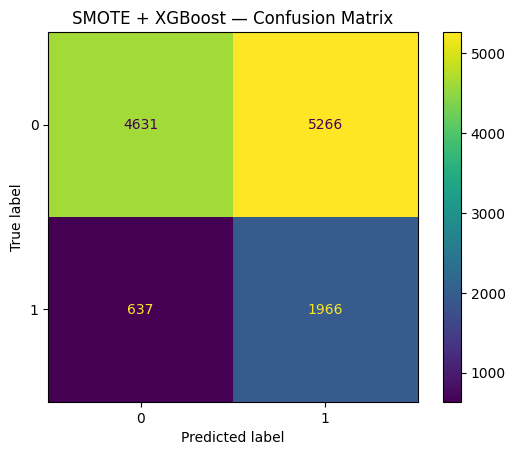

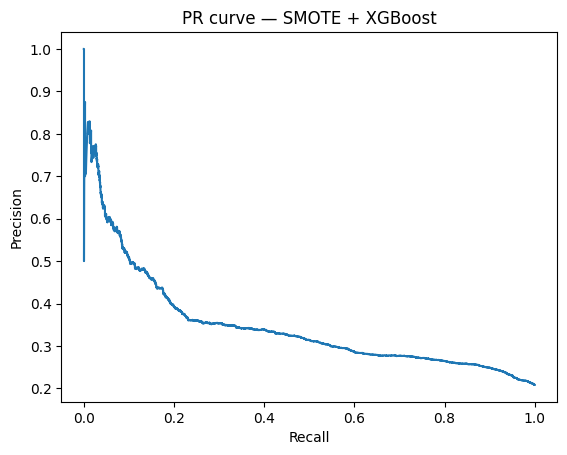

In [24]:
# SMOTE + XGBoost (threshold tuning)
smote_xgb = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42, k_neighbors=5)),
    ("clf", XGBClassifier(
        n_estimators=400,
        max_depth=5,
        learning_rate=0.08,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="logloss",
        use_label_encoder=False,
        # keep scale_pos_weight=1.0 because SMOTE balances the classes
        scale_pos_weight=1.0,
        random_state=42
    ))
])

smote_xgb.fit(X_train, y_train)
probs = smote_xgb.predict_proba(X_test)[:, 1]

prec, rec, thr = precision_recall_curve(y_test, probs)
f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.argmax(f1s)
thr_opt = thr[best_idx]
y_pred = (probs >= thr_opt).astype(int)

print("\n=== SMOTE + XGBoost (tuned) ===")
print("Chosen threshold:", round(float(thr_opt), 3), "F1:", round(float(f1s[best_idx]), 3))
print(classification_report(y_test, y_pred, digits=3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("SMOTE + XGBoost — Confusion Matrix")
plt.show()

plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR curve — SMOTE + XGBoost")
plt.show()

rows.append({
    "model": "SMOTE+XGBoost",
    "threshold": float(thr_opt),
    "accuracy": accuracy_score(y_test, y_pred),
    "precision_1": precision_score(y_test, y_pred, zero_division=0),
    "recall_1": recall_score(y_test, y_pred),
    "f1_1": f1_score(y_test, y_pred)
})


=== SMOTE + LogReg (tuned) ===
Chosen threshold: 0.408 F1: 0.396
              precision    recall  f1-score   support

           0      0.895     0.376     0.529      9897
           1      0.260     0.833     0.396      2603

    accuracy                          0.471     12500
   macro avg      0.578     0.605     0.463     12500
weighted avg      0.763     0.471     0.502     12500



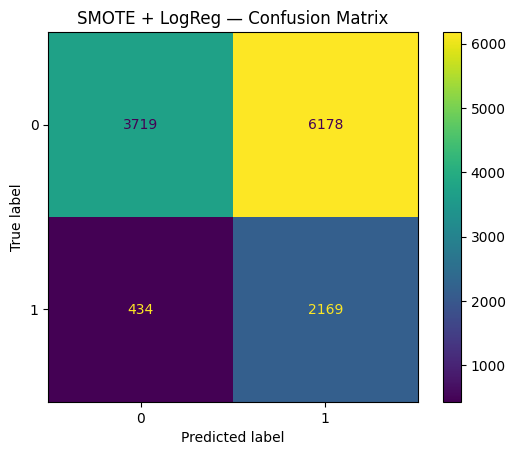

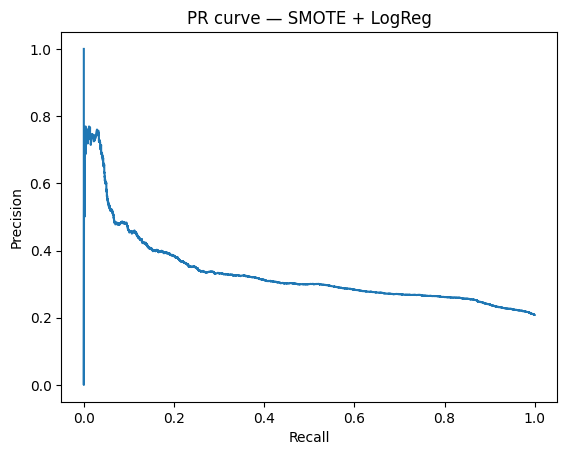

In [25]:
# SMOTE + Logistic Regression (threshold tuning)
smote_log = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42, k_neighbors=5)),
    ("clf", LogisticRegression(
        C=1.0, penalty="l2", solver="lbfgs",
        max_iter=2000, class_weight=None, n_jobs=-1
    ))
])

smote_log.fit(X_train, y_train)
probs = smote_log.predict_proba(X_test)[:, 1]

prec, rec, thr = precision_recall_curve(y_test, probs)
f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.argmax(f1s)
thr_opt = thr[best_idx]
y_pred = (probs >= thr_opt).astype(int)

print("\n=== SMOTE + LogReg (tuned) ===")
print("Chosen threshold:", round(float(thr_opt), 3), "F1:", round(float(f1s[best_idx]), 3))
print(classification_report(y_test, y_pred, digits=3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("SMOTE + LogReg — Confusion Matrix")
plt.show()

plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR curve — SMOTE + LogReg")
plt.show()

rows.append({
    "model": "SMOTE+LogReg",
    "threshold": float(thr_opt),
    "accuracy": accuracy_score(y_test, y_pred),
    "precision_1": precision_score(y_test, y_pred, zero_division=0),
    "recall_1": recall_score(y_test, y_pred),
    "f1_1": f1_score(y_test, y_pred)
})

In [29]:
# Example: SMOTE + XGBoost
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

smote = SMOTE(random_state=42)

xgb_smote_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('clf', XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

xgb_smote_model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:49:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oh',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=50))]),
                                                  ['state_registration',
                                                   'vehicle_type', 'pre_crash',
                                                   'travel_direction']),
                                                 ('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('s...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [30]:
def evaluate_with_optimal_threshold(model, X_test, y_test, label):
    """Find threshold that maximizes F1 on y_test, then return metrics."""
    probs = model.predict_proba(X_test)[:,1]
    ...

In [32]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Define SMOTE
smote = SMOTE(random_state=42)

# SMOTE + XGBoost
xgb_smote_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('clf', XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])
xgb_smote_model.fit(X_train, y_train)

# SMOTE + Logistic Regression
logreg_smote_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('clf', LogisticRegression(max_iter=500, solver='lbfgs'))
])
logreg_smote_model.fit(X_train, y_train)

print("✅ Both SMOTE models trained and ready: xgb_smote_model, logreg_smote_model")


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:50:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Both SMOTE models trained and ready: xgb_smote_model, logreg_smote_model


In [33]:
rows.append(evaluate_with_optimal_threshold(xgb_smote_model, X_test, y_test, "SMOTE + XGBoost"))
rows.append(evaluate_with_optimal_threshold(logreg_smote_model, X_test, y_test, "SMOTE + LogReg"))


Collected result rows: 6


,model,threshold,accuracy,precision_1,recall_1,f1_1
0,XGBoost,0.477450,0.62392,0.303852,0.624280,0.408754
1,RandomForest,0.492084,0.63152,0.306099,0.607376,0.407055
2,SMOTE+XGBoost,0.256352,0.52776,0.271847,0.755282,0.399797
3,LogReg,0.517444,0.57880,0.283929,0.671917,0.399178
4,SMOTE+LogReg,0.407953,0.47104,0.259854,0.833269,0.396164
5,DecisionTree,0.523117,0.63592,0.302274,0.572032,0.395537


Saved: model_results_summary_all.csv
Saved: model_comparison_all.png


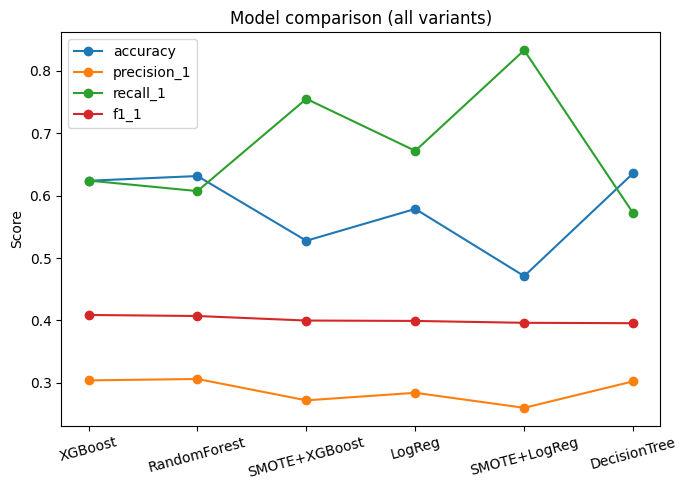

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Make sure we have a usable rows list
if "rows" not in locals():
    rows = []
# drop any Nones or non-dict items
rows = [r for r in rows if isinstance(r, dict)]

print(f"Collected result rows: {len(rows)}")
if not rows:
    raise RuntimeError("rows is empty. Re-run the cells that append model results (evaluate_with_optimal_threshold(...)).")

# 2) Build a dataframe from the fresh rows
new_df = pd.DataFrame(rows).sort_values("f1_1", ascending=False).reset_index(drop=True)

# 3) Merge with earlier results_df if it exists
try:
    assert isinstance(results_df, pd.DataFrame)
    combined_df = pd.concat([results_df, new_df], ignore_index=True)
    # optional: dedupe by model+threshold
    combined_df = (combined_df
                   .drop_duplicates(subset=["model","threshold"], keep="last")
                   .sort_values("f1_1", ascending=False)
                   .reset_index(drop=True))
except Exception:
    combined_df = new_df

results_df = combined_df  # keep a single canonical variable
display(results_df)

# 4) Save a CSV
results_df.to_csv("model_results_summary_all.csv", index=False)
print("Saved: model_results_summary_all.csv")

# 5) Plot comparison
plt.figure(figsize=(7,5))
metrics = ["accuracy","precision_1","recall_1","f1_1"]
for metric in metrics:
    if metric in results_df.columns:
        plt.plot(results_df["model"], results_df[metric], marker="o", label=metric)
plt.xticks(rotation=15)
plt.ylabel("Score")
plt.title("Model comparison (all variants)")
plt.legend()
plt.tight_layout()
plt.savefig("model_comparison_all.png", dpi=150, bbox_inches="tight")
print("Saved: model_comparison_all.png")
plt.show()